In [71]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import cv2
import time
import os
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import joblib

In [72]:
 
MAGNET_STRENGTH = 0.058477513103711194
 

sensor_mask = [True, True, True, True, True, True, True, False]
WORKING_SENSOR_COUNT = sum(sensor_mask)
TOTAL_SENSOR_COUNT = len(sensor_mask)

surface_points = {
    4: (-.13, .1325, 0),
    5: (0, .1325, 0), 
    8: (.13, .1325, 0),
    9: (-.13, 0, 0),
    12: (0, 0, 0),
    13: (.13, 0, 0),
    16: (-.13, -.1325, 0),
    17: (0, -.1325, 0),
    20: (.13, -.1325, 0)
}

sensor_number_to_aruco_id_map = {
    0: 16,
    1: 17,
    2: 20,
    3: 13,
    4: 8,
    5: 5,
    6: 4,
    7: 9,  # broken sensor
}

#get full sensor positions from aruco ids positions, subtract 2.4 csm from the z axis of each aruco id position
full_sensor_positions = np.array([surface_points[sensor_number_to_aruco_id_map[i]] for i in range(TOTAL_SENSOR_COUNT)])
full_sensor_positions[:, 2] -= 0.024  # subtract 2.4 cm from z axis to get sensor positions

sensor_positions = full_sensor_positions[sensor_mask]
# #get centroid of all sensors
# centroid = np.mean(full_sensor_positions, axis=0)

# #center all sensor positions around centroid
# full_sensor_positions -= centroid
# sensor_positions = full_sensor_positions[sensor_mask]

 

In [ ]:
data = pd.read_csv('_data_collected/magnet_data.csv')

def euler_to_quaternion(roll, pitch, yaw):
    # roll = rx, pitch = ry, yaw = rz
    qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
    qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
    qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    return np.array([qx, qy, qz, qw])


features = []
targets = []
for idx, row in data.iterrows():
    x, y, z = row[['x', 'y', 'z']].values.astype(np.float32)
    rx, ry, rz = row[['rx', 'ry', 'rz']].values.astype(np.float32)
    # ry = 0.0  # Ignore y-axis rotation

    # Convert Euler angles to quaternion
    quat = euler_to_quaternion(rx, ry, rz)  # [qx, qy, qz, qw]

    # Target: position + quaternion
    target = np.concatenate([[x, y, z], quat]).astype(np.float32)
     
    sensor_tokens = []
    for i, mask in enumerate(sensor_mask):
        if mask:
            start_col = 6 + i*3
            readings = row.iloc[start_col:start_col+3].values.astype(np.float32)
            readings_SI = readings * 1e-6  # Convert µT to T
            pos = sensor_positions[i]
            token = np.concatenate([pos, readings_SI, [MAGNET_STRENGTH]])  # [sensor_x, sensor_y, sensor_z, reading_x, reading_y, reading_z, strength]
            sensor_tokens.append(token)
    features.append(np.stack(sensor_tokens))
    targets.append(target)


features = np.array(features)  # shape (N, 7, 7)
targets = np.array(targets)    # shape (N, 7)

from sklearn.preprocessing import StandardScaler
sensor_positions_all = []  # positions for all samples
sensor_readings_all = []   # readings for all samples
magnet_strengths_all = []  # strengths for all samples

for sample in features:  # features shape (N, 7, 7)
    for token in sample:
        sensor_positions_all.append(token[:3])
        sensor_readings_all.append(token[3:6])
        magnet_strengths_all.append(token[6])

# Fit separate scalers
scaler_pos =  
scaler_readings = StandardScaler().fit(sensor_readings_all)
scaler_strength = StandardScaler().fit(np.array(magnet_strengths_all).reshape(-1, 1))

# Apply normalization per sample
features_norm = []
for sample in features:
    tokens_norm = []
    for token in sample:
        pos_norm = scaler_pos.transform(token[:3].reshape(1, -1)).flatten()
        read_norm = scaler_readings.transform(token[3:6].reshape(1, -1)).flatten()
        str_norm = scaler_strength.transform(token[6].reshape(1, -1)).flatten()
        token_norm = np.concatenate([pos_norm, read_norm, str_norm])
        tokens_norm.append(token_norm)
    features_norm.append(tokens_norm)
features_norm = np.array(features_norm)

# Save all scalers
joblib.dump(scaler_pos, 'scaler_pos.joblib')
joblib.dump(scaler_readings, 'scaler_readings.joblib')
joblib.dump(scaler_strength, 'scaler_strength.joblib')
# Normalize targets
scaler_y = StandardScaler()
targets_norm = scaler_y.fit_transform(targets)

# Train/val/test split (e.g., 70/15/15) and shuffle
X_train, X_temp, y_train, y_temp = train_test_split(features_norm, targets_norm, test_size=0.3 , shuffle = False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5 , shuffle = False)




SyntaxError: invalid syntax (4237546175.py, line 53)

In [75]:
targets.shape

(23495, 7)

In [ ]:
features.shape

(681, 7, 7)

In [ ]:
import joblib
 
joblib.dump(scaler_y, 'scaler_y.joblib')


['scaler_y.joblib']

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MagnetDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float)
        self.targets = torch.tensor(targets, dtype=torch.float)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = MagnetDataset(X_train, y_train)
val_dataset = MagnetDataset(X_val, y_val)
test_dataset = MagnetDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:


class MagnetTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, n_tokens=7, in_dim=7, out_dim=7):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.agg = nn.Linear(n_tokens * d_model, d_model)
        self.head = nn.Linear(d_model, out_dim)
    def forward(self, x):
        x = self.input_proj(x)
        x = x.permute(1, 0, 2)
        x = self.encoder(x)
        x = x.permute(1, 0, 2)
        x = x.reshape(x.shape[0], -1)
        x = self.agg(x)
        out = self.head(x)
        return out

model = MagnetTransformer()


/home/aayush-ubuntu/miniconda3/envs/magnet/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn

class SensorViTRegressor(nn.Module):
    def __init__(self, 
                 n_tokens=7,        # number of sensors (tokens)
                 in_dim=7,          # features per sensor
                 d_model=128,       # transformer model dim
                 nhead=8,           # attention heads
                 num_layers=4,      # transformer layers
                 out_dim=7,         # regression output [pos, quat]
                 patch_dropout=0.1,
                 mlp_dim=256,
                 use_positional_encoding=True):
        super().__init__()
        
        # Patch embedding: Linear projection from in_dim to d_model
        self.patch_embed = nn.Linear(in_dim, d_model)
        
        # Optional positional embedding
        if use_positional_encoding:
            self.pos_embed = nn.Parameter(torch.zeros(1, n_tokens, d_model))
        else:
            self.pos_embed = None
        
        # Transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=mlp_dim,
            dropout=patch_dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Flatten all tokens for regression output
        self.pre_head = nn.Linear(n_tokens * d_model, mlp_dim)
        self.act = nn.ReLU()
        self.head = nn.Linear(mlp_dim, out_dim)
        
    def forward(self, x):
        # x: (batch_size, n_tokens, in_dim)
        x = self.patch_embed(x)  # (batch_size, n_tokens, d_model)
        if self.pos_embed is not None:
            x = x + self.pos_embed  # add positional encoding
        x = self.encoder(x)  # (batch_size, n_tokens, d_model)
        x = x.reshape(x.shape[0], -1)  # flatten all tokens
        x = self.pre_head(x)
        x = self.act(x)
        out = self.head(x)
        return out  # (batch_size, out_dim)


In [ ]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SensorViTRegressor().to(device)

# Dummy input (for 7 sensors, each with 7 features)
batch_size = 10
input_tensor = torch.randn(batch_size, 7, 7).to(device)
output = model(input_tensor)  # shape (batch_size, 7)
print("Output shape:", output.shape)


Output shape: torch.Size([10, 7])


In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

y_pred = None
for epoch in range(100):
    model.train()
    train_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dataset)
    print(f"Epoch {epoch+1}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")


Epoch 1 [Val]: 100%|██████████| 111/111 [00:00<00:00, 701.16it/s]


Epoch 1: train_loss=0.222776, val_loss=0.721345


Epoch 2 [Val]: 100%|██████████| 111/111 [00:00<00:00, 750.76it/s]


Epoch 2: train_loss=0.181198, val_loss=0.715832


Epoch 3 [Val]: 100%|██████████| 111/111 [00:00<00:00, 704.95it/s]


Epoch 3: train_loss=0.176482, val_loss=0.740460


Epoch 4 [Val]: 100%|██████████| 111/111 [00:00<00:00, 787.16it/s]


Epoch 4: train_loss=0.175532, val_loss=0.748465


Epoch 5 [Val]: 100%|██████████| 111/111 [00:00<00:00, 753.00it/s]


Epoch 5: train_loss=0.172420, val_loss=0.674681


Epoch 6 [Val]: 100%|██████████| 111/111 [00:00<00:00, 776.88it/s]


Epoch 6: train_loss=0.173009, val_loss=0.700093


Epoch 7 [Val]: 100%|██████████| 111/111 [00:00<00:00, 774.78it/s]


Epoch 7: train_loss=0.171159, val_loss=0.653867


Epoch 8 [Val]: 100%|██████████| 111/111 [00:00<00:00, 763.89it/s]


Epoch 8: train_loss=0.168286, val_loss=0.708745


Epoch 9 [Val]: 100%|██████████| 111/111 [00:00<00:00, 747.38it/s]


Epoch 9: train_loss=0.166141, val_loss=0.769595


Epoch 10 [Val]: 100%|██████████| 111/111 [00:00<00:00, 750.90it/s]


Epoch 10: train_loss=0.166513, val_loss=0.658822


Epoch 11 [Val]: 100%|██████████| 111/111 [00:00<00:00, 782.54it/s]


Epoch 11: train_loss=0.166079, val_loss=0.752684


Epoch 12 [Val]: 100%|██████████| 111/111 [00:00<00:00, 606.79it/s]


Epoch 12: train_loss=0.163877, val_loss=0.746814


Epoch 13 [Val]: 100%|██████████| 111/111 [00:00<00:00, 755.42it/s]


Epoch 13: train_loss=0.166046, val_loss=0.821968


Epoch 14 [Val]: 100%|██████████| 111/111 [00:00<00:00, 441.78it/s]


Epoch 14: train_loss=0.165262, val_loss=0.702656


Epoch 15 [Val]: 100%|██████████| 111/111 [00:00<00:00, 643.39it/s]


Epoch 15: train_loss=0.165082, val_loss=0.668072


Epoch 16 [Val]: 100%|██████████| 111/111 [00:00<00:00, 705.67it/s]


Epoch 16: train_loss=0.164141, val_loss=0.767200


Epoch 17 [Val]: 100%|██████████| 111/111 [00:00<00:00, 772.85it/s]


Epoch 17: train_loss=0.164582, val_loss=0.818376


Epoch 18 [Val]: 100%|██████████| 111/111 [00:00<00:00, 827.86it/s]


Epoch 18: train_loss=0.160031, val_loss=0.705021


Epoch 19 [Val]: 100%|██████████| 111/111 [00:00<00:00, 780.92it/s]


Epoch 19: train_loss=0.160431, val_loss=0.673849


Epoch 20 [Val]: 100%|██████████| 111/111 [00:00<00:00, 831.82it/s]


Epoch 20: train_loss=0.157741, val_loss=0.660406


Epoch 21 [Val]: 100%|██████████| 111/111 [00:00<00:00, 636.16it/s]


Epoch 21: train_loss=0.164162, val_loss=0.751619


Epoch 22 [Val]: 100%|██████████| 111/111 [00:00<00:00, 749.52it/s]


Epoch 22: train_loss=0.159243, val_loss=0.708547


Epoch 23 [Val]: 100%|██████████| 111/111 [00:00<00:00, 849.92it/s]


Epoch 23: train_loss=0.161208, val_loss=0.804841


Epoch 24 [Val]: 100%|██████████| 111/111 [00:00<00:00, 812.42it/s]


Epoch 24: train_loss=0.163321, val_loss=0.669083


Epoch 25 [Val]: 100%|██████████| 111/111 [00:00<00:00, 667.67it/s]


Epoch 25: train_loss=0.154872, val_loss=0.772807


Epoch 26 [Val]: 100%|██████████| 111/111 [00:00<00:00, 618.90it/s]


Epoch 26: train_loss=0.157724, val_loss=0.765883


Epoch 27 [Val]: 100%|██████████| 111/111 [00:00<00:00, 820.31it/s]


Epoch 27: train_loss=0.156053, val_loss=0.682196


Epoch 28 [Val]: 100%|██████████| 111/111 [00:00<00:00, 790.63it/s]


Epoch 28: train_loss=0.155945, val_loss=0.662818


Epoch 29 [Val]: 100%|██████████| 111/111 [00:00<00:00, 744.99it/s]


Epoch 29: train_loss=0.155975, val_loss=0.805206


Epoch 30 [Val]: 100%|██████████| 111/111 [00:00<00:00, 563.19it/s]


Epoch 30: train_loss=0.155100, val_loss=0.715344


Epoch 31 [Val]: 100%|██████████| 111/111 [00:00<00:00, 731.04it/s]


Epoch 31: train_loss=0.156389, val_loss=0.771768


Epoch 32 [Val]: 100%|██████████| 111/111 [00:00<00:00, 665.67it/s]


Epoch 32: train_loss=0.154770, val_loss=0.704373


Epoch 33 [Val]: 100%|██████████| 111/111 [00:00<00:00, 713.82it/s]


Epoch 33: train_loss=0.158120, val_loss=0.673238


Epoch 34 [Val]: 100%|██████████| 111/111 [00:00<00:00, 629.48it/s]


Epoch 34: train_loss=0.152879, val_loss=0.690866


Epoch 35 [Val]: 100%|██████████| 111/111 [00:00<00:00, 714.88it/s]


Epoch 35: train_loss=0.155627, val_loss=0.647125


Epoch 36 [Val]: 100%|██████████| 111/111 [00:00<00:00, 495.68it/s]


Epoch 36: train_loss=0.152015, val_loss=0.669334


Epoch 37 [Val]: 100%|██████████| 111/111 [00:00<00:00, 740.80it/s]


Epoch 37: train_loss=0.151906, val_loss=0.655838


Epoch 38 [Val]: 100%|██████████| 111/111 [00:00<00:00, 721.43it/s]


Epoch 38: train_loss=0.152418, val_loss=0.776781


Epoch 39 [Val]: 100%|██████████| 111/111 [00:00<00:00, 826.03it/s]


Epoch 39: train_loss=0.153488, val_loss=0.694679


Epoch 40 [Val]: 100%|██████████| 111/111 [00:00<00:00, 680.45it/s]


Epoch 40: train_loss=0.151234, val_loss=0.734517


Epoch 41 [Val]: 100%|██████████| 111/111 [00:00<00:00, 703.34it/s]


Epoch 41: train_loss=0.152639, val_loss=0.745239


Epoch 42 [Val]: 100%|██████████| 111/111 [00:00<00:00, 786.42it/s]


Epoch 42: train_loss=0.154881, val_loss=0.676027


Epoch 43 [Val]: 100%|██████████| 111/111 [00:00<00:00, 579.15it/s]


Epoch 43: train_loss=0.150519, val_loss=0.738493


Epoch 44 [Val]: 100%|██████████| 111/111 [00:00<00:00, 676.86it/s]


Epoch 44: train_loss=0.152371, val_loss=0.725448


Epoch 45 [Val]: 100%|██████████| 111/111 [00:00<00:00, 712.76it/s]


Epoch 45: train_loss=0.148445, val_loss=0.797375


Epoch 46 [Val]: 100%|██████████| 111/111 [00:00<00:00, 459.19it/s]


Epoch 46: train_loss=0.148043, val_loss=0.750552


Epoch 47 [Val]: 100%|██████████| 111/111 [00:00<00:00, 482.08it/s]


Epoch 47: train_loss=0.149917, val_loss=0.784410


Epoch 48 [Val]: 100%|██████████| 111/111 [00:00<00:00, 438.66it/s]


Epoch 48: train_loss=0.150187, val_loss=0.715361


Epoch 49 [Val]: 100%|██████████| 111/111 [00:00<00:00, 741.27it/s]


Epoch 49: train_loss=0.149548, val_loss=0.721521


Epoch 50 [Val]: 100%|██████████| 111/111 [00:00<00:00, 737.99it/s]


Epoch 50: train_loss=0.148380, val_loss=0.783809


Epoch 51 [Val]: 100%|██████████| 111/111 [00:00<00:00, 742.44it/s]


Epoch 51: train_loss=0.148893, val_loss=0.708641


Epoch 52 [Val]: 100%|██████████| 111/111 [00:00<00:00, 744.94it/s]


Epoch 52: train_loss=0.152030, val_loss=0.746703


Epoch 53 [Val]: 100%|██████████| 111/111 [00:00<00:00, 711.27it/s]


Epoch 53: train_loss=0.153959, val_loss=0.748255


Epoch 54 [Val]: 100%|██████████| 111/111 [00:00<00:00, 762.43it/s]


Epoch 54: train_loss=0.150318, val_loss=0.737913


Epoch 55 [Val]: 100%|██████████| 111/111 [00:00<00:00, 726.10it/s]


Epoch 55: train_loss=0.149106, val_loss=0.718244


Epoch 56 [Val]: 100%|██████████| 111/111 [00:00<00:00, 725.53it/s]


Epoch 56: train_loss=0.146264, val_loss=0.781451


Epoch 57 [Val]: 100%|██████████| 111/111 [00:00<00:00, 755.94it/s]


Epoch 57: train_loss=0.148725, val_loss=0.717373


Epoch 58 [Val]: 100%|██████████| 111/111 [00:00<00:00, 763.02it/s]


Epoch 58: train_loss=0.148210, val_loss=0.783385


Epoch 59 [Val]: 100%|██████████| 111/111 [00:00<00:00, 749.56it/s]


Epoch 59: train_loss=0.147901, val_loss=0.762411


Epoch 60 [Val]: 100%|██████████| 111/111 [00:00<00:00, 597.34it/s]


Epoch 60: train_loss=0.146058, val_loss=0.742753


Epoch 61 [Val]: 100%|██████████| 111/111 [00:00<00:00, 725.83it/s]


Epoch 61: train_loss=0.147907, val_loss=0.759360


Epoch 62 [Val]: 100%|██████████| 111/111 [00:00<00:00, 772.74it/s]


Epoch 62: train_loss=0.148432, val_loss=0.715079


Epoch 63 [Val]: 100%|██████████| 111/111 [00:00<00:00, 745.10it/s]


Epoch 63: train_loss=0.147645, val_loss=0.747778


Epoch 64 [Val]: 100%|██████████| 111/111 [00:00<00:00, 576.52it/s]


Epoch 64: train_loss=0.149463, val_loss=0.717550


Epoch 65 [Val]: 100%|██████████| 111/111 [00:00<00:00, 745.39it/s]


Epoch 65: train_loss=0.149306, val_loss=0.775155


Epoch 66 [Val]: 100%|██████████| 111/111 [00:00<00:00, 696.32it/s]


Epoch 66: train_loss=0.146749, val_loss=0.760729


Epoch 67 [Val]: 100%|██████████| 111/111 [00:00<00:00, 677.61it/s]


Epoch 67: train_loss=0.148651, val_loss=0.855260


Epoch 68 [Val]: 100%|██████████| 111/111 [00:00<00:00, 666.17it/s]


Epoch 68: train_loss=0.147293, val_loss=0.744884


Epoch 69 [Val]: 100%|██████████| 111/111 [00:00<00:00, 683.79it/s]


Epoch 69: train_loss=0.146160, val_loss=0.803664


Epoch 70 [Val]: 100%|██████████| 111/111 [00:00<00:00, 658.93it/s]


Epoch 70: train_loss=0.146440, val_loss=0.783810


Epoch 71 [Val]: 100%|██████████| 111/111 [00:00<00:00, 726.70it/s]


Epoch 71: train_loss=0.146637, val_loss=0.801004


Epoch 72 [Val]: 100%|██████████| 111/111 [00:00<00:00, 681.59it/s]


Epoch 72: train_loss=0.146374, val_loss=0.739541


Epoch 73 [Val]: 100%|██████████| 111/111 [00:00<00:00, 687.19it/s]


Epoch 73: train_loss=0.148985, val_loss=0.715874


Epoch 74 [Val]: 100%|██████████| 111/111 [00:00<00:00, 709.43it/s]


Epoch 74: train_loss=0.147242, val_loss=0.734802


Epoch 75 [Val]: 100%|██████████| 111/111 [00:00<00:00, 717.86it/s]


Epoch 75: train_loss=0.147388, val_loss=0.723792


Epoch 76 [Val]: 100%|██████████| 111/111 [00:00<00:00, 680.63it/s]


Epoch 76: train_loss=0.145135, val_loss=0.755169


Epoch 77 [Val]: 100%|██████████| 111/111 [00:00<00:00, 823.73it/s]


Epoch 77: train_loss=0.145305, val_loss=0.778621


Epoch 78 [Val]: 100%|██████████| 111/111 [00:00<00:00, 760.28it/s]


Epoch 78: train_loss=0.145250, val_loss=0.803112


Epoch 79 [Val]: 100%|██████████| 111/111 [00:00<00:00, 836.00it/s]


Epoch 79: train_loss=0.146440, val_loss=0.722774


Epoch 80 [Val]: 100%|██████████| 111/111 [00:00<00:00, 828.99it/s]


Epoch 80: train_loss=0.145959, val_loss=0.774192


Epoch 81 [Val]: 100%|██████████| 111/111 [00:00<00:00, 785.31it/s]


Epoch 81: train_loss=0.146115, val_loss=0.747166


Epoch 82 [Val]: 100%|██████████| 111/111 [00:00<00:00, 805.70it/s]


Epoch 82: train_loss=0.145171, val_loss=0.742589


Epoch 83 [Val]: 100%|██████████| 111/111 [00:00<00:00, 794.66it/s]


Epoch 83: train_loss=0.144846, val_loss=0.717638


Epoch 84 [Val]: 100%|██████████| 111/111 [00:00<00:00, 808.25it/s]


Epoch 84: train_loss=0.149808, val_loss=0.715432


Epoch 85 [Val]: 100%|██████████| 111/111 [00:00<00:00, 715.87it/s]


Epoch 85: train_loss=0.143984, val_loss=0.749917


Epoch 86 [Val]: 100%|██████████| 111/111 [00:00<00:00, 782.94it/s]


Epoch 86: train_loss=0.145414, val_loss=0.698273


Epoch 87 [Val]: 100%|██████████| 111/111 [00:00<00:00, 829.30it/s]


Epoch 87: train_loss=0.146059, val_loss=0.736187


Epoch 88 [Val]: 100%|██████████| 111/111 [00:00<00:00, 798.09it/s]


Epoch 88: train_loss=0.143789, val_loss=0.692393


Epoch 89 [Val]: 100%|██████████| 111/111 [00:00<00:00, 824.29it/s]


Epoch 89: train_loss=0.143685, val_loss=0.790369


Epoch 90 [Val]: 100%|██████████| 111/111 [00:00<00:00, 819.81it/s]


Epoch 90: train_loss=0.144625, val_loss=0.781752


Epoch 91 [Val]: 100%|██████████| 111/111 [00:00<00:00, 804.11it/s]


Epoch 91: train_loss=0.144018, val_loss=0.735120


Epoch 92 [Val]: 100%|██████████| 111/111 [00:00<00:00, 815.44it/s]


Epoch 92: train_loss=0.146434, val_loss=0.797586


Epoch 93 [Val]: 100%|██████████| 111/111 [00:00<00:00, 821.72it/s]


Epoch 93: train_loss=0.144267, val_loss=0.778646


Epoch 94 [Val]: 100%|██████████| 111/111 [00:00<00:00, 684.58it/s]


Epoch 94: train_loss=0.143762, val_loss=0.757697


Epoch 95 [Val]: 100%|██████████| 111/111 [00:00<00:00, 838.57it/s]


Epoch 95: train_loss=0.147044, val_loss=0.754397


Epoch 96 [Val]: 100%|██████████| 111/111 [00:00<00:00, 810.70it/s]


Epoch 96: train_loss=0.146141, val_loss=0.778828


Epoch 97 [Val]: 100%|██████████| 111/111 [00:00<00:00, 805.94it/s]


Epoch 97: train_loss=0.144900, val_loss=0.729233


Epoch 98 [Val]: 100%|██████████| 111/111 [00:00<00:00, 824.65it/s]


Epoch 98: train_loss=0.145254, val_loss=0.754927


Epoch 99 [Val]: 100%|██████████| 111/111 [00:00<00:00, 839.05it/s]


Epoch 99: train_loss=0.142369, val_loss=0.764161


Epoch 100 [Val]: 100%|██████████| 111/111 [00:00<00:00, 803.98it/s]

Epoch 100: train_loss=0.145173, val_loss=0.765015


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Flatten your features for kNN (N, 7, 7) -> (N, 49)
X = features.reshape(features.shape[0], -1)
y = targets  # (N, 7)

# Normalize y for kNN
scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

#x too

scaler_X = StandardScaler()
X_norm = scaler_X.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

# Fit kNN regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"kNN Test MSE: {mse:.4f}")


kNN Test MSE: 0.3093


In [ ]:
# Test set evaluation for transformer
model.eval()
test_loss = 0
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Test"):
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        y_pred_list.append(pred.cpu().numpy())
        y_true_list.append(yb.cpu().numpy())
        loss = loss_fn(pred, yb)
        test_loss += loss.item() * xb.size(0)
test_loss /= len(test_dataset)

# Stack all batches into full arrays
y_pred = np.vstack(y_pred_list)
y_test = np.vstack(y_true_list)


Test: 100%|██████████| 111/111 [00:00<00:00, 627.66it/s]


In [ ]:
# calculate test mse for transformer
mse_transformer = mean_squared_error(y_test, y_pred)
print(f"Transformer Test MSE: {mse_transformer:.4f}")   

Transformer Test MSE: 3.5534


In [ ]:
print("hello")

hello


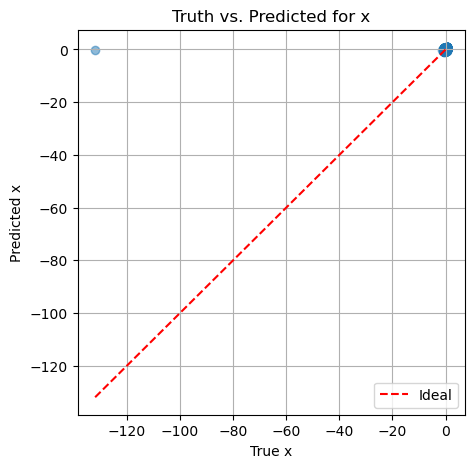

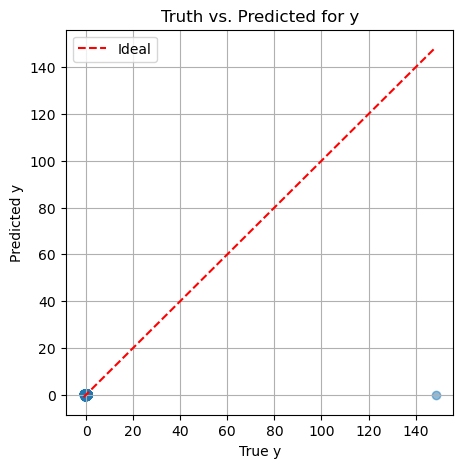

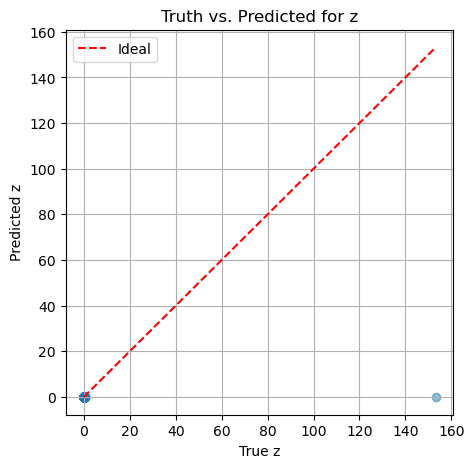

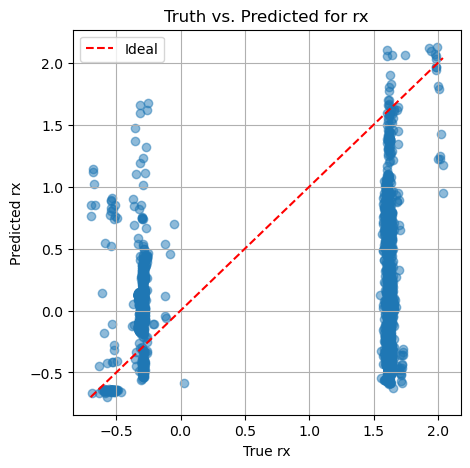

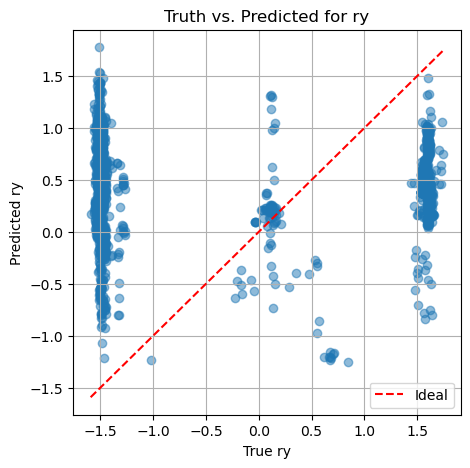

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# y_test: true values, shape (N, num_features)
# y_pred: predicted values, shape (N, num_features)
# feature_names: list of names for each target feature

feature_names = ['x', 'y', 'z', 'rx', 'ry']  # or ['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']

for i, name in enumerate(feature_names):
    plt.figure(figsize=(5,5))
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_test[:, i].min(), y_test[:, i].max()],
             [y_test[:, i].min(), y_test[:, i].max()], 'r--', label='Ideal')
    plt.xlabel('True {}'.format(name))
    plt.ylabel('Predicted {}'.format(name))
    plt.title('Truth vs. Predicted for {}'.format(name))
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
#save model
torch.save(model.state_dict(), 'magnet_transformer_model.pth')

In [ ]:
scaler_y

,copy,True
,with_mean,True
,with_std,True


In [ ]:
#load magnetic_data_testing.csv for testing the transformer model


data = pd.read_csv('_data_collected/magnet_data_testing.csv')

features = []
for idx, row in data.iterrows():
    sensor_tokens = []
    for i, mask in enumerate(sensor_mask):
        if mask:
            start_col = 6 + i*3
            readings = row.iloc[start_col:start_col+3].values.astype(np.float32)
            readings_SI = readings * 1e-6  # Convert µT to T
            pos = sensor_positions[i]
            token = np.concatenate([pos, readings_SI, [MAGNET_STRENGTH]])  # [sensor_x, sensor_y, sensor_z, reading_x, reading_y, reading_z, strength]
            sensor_tokens.append(token)
    features.append(np.stack(sensor_tokens))
features = np.array(features)  # shape (N, 7, 7)    
features_flat = features.reshape(features.shape[0], -1)
features_norm = scaler_X.transform(features_flat).reshape(features.shape[0], features.shape[1
], features.shape[2])
features_tensor = torch.tensor(features_norm, dtype=torch.float).to(device)

model.eval()
with torch.no_grad():
    preds = model(features_tensor).cpu().numpy()
#inverse transform preds
preds_inv = scaler_y.inverse_transform(preds)



In [ ]:
#calculate error in cm for position and degrees for rotation
true_positions = data[['x', 'y', 'z']].values
pred_positions = preds_inv[:, :3]
pos_errors = np.linalg.norm(true_positions - pred_positions, axis=1) * 100  # convert to cm
mean_pos_error = np.mean(pos_errors)
std_pos_error = np.std(pos_errors)
print(f"Position Error: Mean = {mean_pos_error:.2f} cm, Std = {std_pos_error:.2f} cm")
#calculate error in degrees for rotation
true_rotations = data[['rx', 'ry', 'rz']].values
pred_rotations = preds_inv[:, 3:6]
rot_errors = np.linalg.norm(true_rotations - pred_rotations, axis=1) * 57.2958  # convert to degrees
mean_rot_error = np.mean(rot_errors)
std_rot_error = np.std(rot_errors)
print(f"Rotation Error: Mean = {mean_rot_error:.2f} deg, Std = {std_rot_error:.2f} deg")

Position Error: Mean = 7.03 cm, Std = 5.53 cm
Rotation Error: Mean = 123.18 deg, Std = 24.71 deg
